# Simulation 5X
In this notebook we run a few sensitivity studies starting from the results in *Simulation5.ipynb*.

### Importing libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.ndimage import uniform_filter1d

import constants as const
import server as srv
import agent as agn

In this implementation all the parameters of the game are defined in the *const.py* script. A *Server* has 4 ports, 5 potential vulnerable webservices it may be running, 4 potential vulnerable parameter it may receive at 2 different levels of depth.

This implies 45 possible concrete actions for the attacker.

Setting a random seed

In [2]:
np.random.seed(0)

### Random server
We define a simple function to instantiate random servers.

In [3]:
def random_server():
    vulnport = np.random.randint(0,const.N_PORTS)
    vulntype = np.random.choice(const.VULNTYPES)
    
    if(vulntype==const.VULNTYPE_ACCESSPOINT):
        vulnlevel = const.VULNLEVEL_NONE
        n = np.argmax(np.random.multinomial(1,[.5,.3,.1,.05,.05]))+1
        vulnvalue = np.random.choice(const.ACCESSPOINTS,n,replace=False)
    elif(vulntype==const.VULNTYPE_PARAM):
        vulnlevel = np.random.choice(const.VULNLEVELS)
        vulnvalue = np.random.randint(1,const.N_VULNPARAMS+1)
        
    return srv.Server(vulnport, vulnlevel, vulntype, vulnvalue)

### Defining a function to create trajectory to follow in imitation learning

We define a function to provide trajectory to imitate as a function of the current running server.

In [4]:
def generate_trajectory(server):
    trajectory = []
    
    # Perform a scan
    trajectory.append(0)
    # Perform a scan
    trajectory.append(server.vulnport+1)
    # Perform a deep read
    trajectory.append(server.vulnport + const.N_PORTS +1)
    
    # Exploit the access point or the parametrized vulnerability
    if(server.vulntype == const.VULNTYPE_ACCESSPOINT):
        vulnport = server.vulnport
        vulnvalue = server.vulnvalue[0]
        #trajectory.append( (const.N_PORTS*2)+1 + vulnport + vulnvalue*const.N_PORTS )
        trajectory.append( (const.N_PORTS*2)+1 + (vulnport*const.N_ACCESSPOINTS) + vulnvalue)
    elif(server.vulntype == const.VULNTYPE_PARAM):
        vulnport = server.vulnport
        vulnvalue = server.vulnvalue
        trajectory.append( const.N_PORTS*(2+const.N_ACCESSPOINTS)+1 + (vulnport*const.N_VULNPARAMS) + (vulnvalue-1) )
    
    return trajectory

## Simulation 5X

In [5]:
nepisodes_learning = 10000
ntrials = 20

steps_im0 = np.zeros((ntrials,nepisodes_learning))
rewards_im0 = np.zeros((ntrials,nepisodes_learning))

for t in tqdm(range(ntrials)):
    
    agt = agn.Agent(verbose=False)
    agt.set_learning_options(exploration=0.3, 
                         learningrate=0.1, 
                         discount=0.9)

    for e in range(nepisodes_learning):
        env = random_server()
        agt.reset(env)

        agt.run_episode()
        steps_im0[t,e] = agt.steps
        rewards_im0[t,e] = agt.rewards  

100%|███████████████████████████████████████████| 20/20 [01:58<00:00,  5.93s/it]


In [6]:
epsilons = [.1,.5,.9]

imitations = [100,200,500]
nepisodes_learning = 100

steps_imN = np.zeros((len(epsilons),ntrials,len(imitations),nepisodes_learning))
rewards_imN = np.zeros((len(epsilons),ntrials,len(imitations),nepisodes_learning))

for j in range(len(epsilons)):

    for i in range(len(imitations)):

        for t in tqdm(range(ntrials)):    

            agt = agn.Agent(verbose=False)
            agt.set_learning_options(exploration=epsilons[j], 
                                 learningrate=0.3, 
                                 discount=0.9)

            for l in range(imitations[i]):
                env = random_server()
                trajectory = generate_trajectory(env)
                agt.reset(env)

                agt.run_trajectory(trajectory)   

            for e in range(nepisodes_learning):
                env = random_server()
                agt.reset(env)

                agt.run_episode()

                steps_imN[j,t,i,e] = agt.steps
                rewards_imN[j,t,i,e] = agt.rewards

100%|███████████████████████████████████████████| 20/20 [00:01<00:00, 17.01it/s]


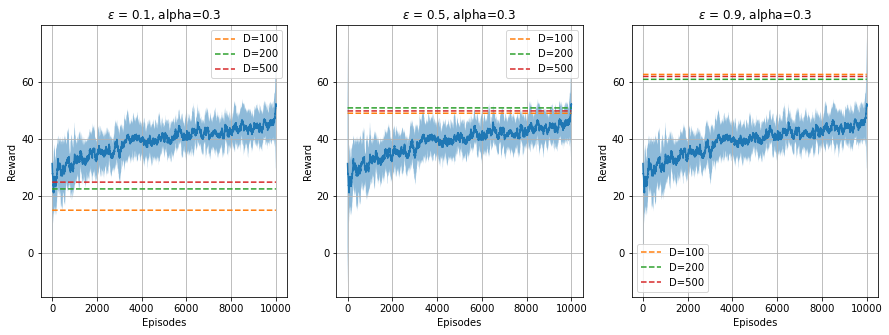

In [7]:
nepisodes_learning = 10000

plt.figure(figsize=(15,5))
for i in range(len(epsilons)):
    
    plt.subplot(1,3,i+1)

    x = np.arange(nepisodes_learning)
    y = np.mean(uniform_filter1d(rewards_im0,size=100,mode='nearest',axis=1),axis=0)
    ystd = np.std(uniform_filter1d(rewards_im0,size=100,mode='nearest'),axis=0)
    plt.plot(x,y)
    plt.fill_between(x,y-ystd,y+ystd,alpha=.5)

    y = [np.mean(rewards_imN[i,:,0,:])]*(nepisodes_learning)
    ystd = np.std(np.mean(rewards_imN[:,0,:],axis=1))
    plt.plot(x,y, label='D=100', linestyle='dashed')

    y = [np.mean(rewards_imN[i,:,1,:])]*(nepisodes_learning)
    ystd = np.std(np.mean(rewards_imN[:,1,:],axis=1))
    plt.plot(x,y, label='D=200', linestyle='dashed')

    y = [np.mean(rewards_imN[i,:,2,:])]*(nepisodes_learning)
    ystd = np.std(np.mean(rewards_imN[:,2,:],axis=1))
    plt.plot(x,y, label='D=500', linestyle='dashed')

    plt.xlabel('Episodes')
    plt.ylabel('Reward')
    plt.title('$\epsilon$ = {0}, alpha=0.3'.format(epsilons[i]))
    plt.legend()
    plt.grid()

plt.savefig('simul5_epsilon.png')
plt.show()

In [8]:
alphas = [.1,.5,.9]

imitations = [100,200,500]
nepisodes_learning = 100

steps_imN = np.zeros((len(epsilons),ntrials,len(imitations),nepisodes_learning))
rewards_imN = np.zeros((len(epsilons),ntrials,len(imitations),nepisodes_learning))

for j in range(len(alphas)):

    for i in range(len(imitations)):

        for t in tqdm(range(ntrials)):    

            agt = agn.Agent(verbose=False)
            agt.set_learning_options(exploration=0.3, 
                                 learningrate=alphas[j], 
                                 discount=0.9)

            for l in range(imitations[i]):
                env = random_server()
                trajectory = generate_trajectory(env)
                agt.reset(env)

                agt.run_trajectory(trajectory)   

            for e in range(nepisodes_learning):
                env = random_server()
                agt.reset(env)

                agt.run_episode()

                steps_imN[j,t,i,e] = agt.steps
                rewards_imN[j,t,i,e] = agt.rewards

100%|███████████████████████████████████████████| 20/20 [00:01<00:00, 14.23it/s]


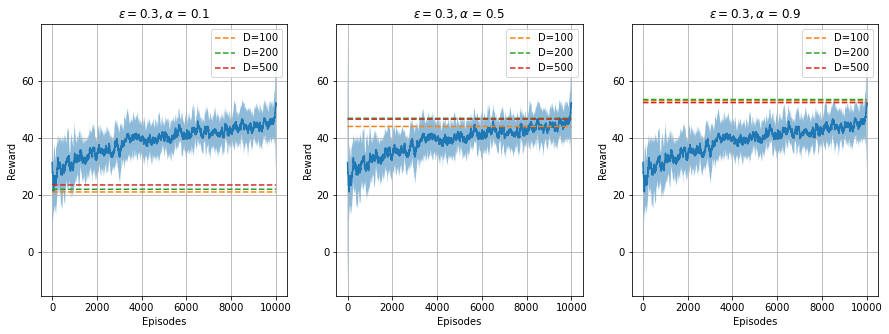

In [9]:
nepisodes_learning = 10000

plt.figure(figsize=(15,5))
for i in range(len(alphas)):
    
    plt.subplot(1,3,i+1)

    x = np.arange(nepisodes_learning)
    y = np.mean(uniform_filter1d(rewards_im0,size=100,mode='nearest',axis=1),axis=0)
    ystd = np.std(uniform_filter1d(rewards_im0,size=100,mode='nearest'),axis=0)
    plt.plot(x,y)
    plt.fill_between(x,y-ystd,y+ystd,alpha=.5)

    y = [np.mean(rewards_imN[i,:,0,:])]*(nepisodes_learning)
    ystd = np.std(np.mean(rewards_imN[:,0,:],axis=1))
    plt.plot(x,y, label='D=100', linestyle='dashed')

    y = [np.mean(rewards_imN[i,:,1,:])]*(nepisodes_learning)
    ystd = np.std(np.mean(rewards_imN[:,1,:],axis=1))
    plt.plot(x,y, label='D=200', linestyle='dashed')

    y = [np.mean(rewards_imN[i,:,2,:])]*(nepisodes_learning)
    ystd = np.std(np.mean(rewards_imN[:,2,:],axis=1))
    plt.plot(x,y, label='D=500', linestyle='dashed')

    plt.xlabel('Episodes')
    plt.ylabel('Reward')
    plt.title('$\epsilon=0.3, \\alpha$ = {0}'.format(epsilons[i]))
    plt.legend()
    plt.grid()

plt.savefig('simul5_alpha.png')
plt.show()